# Evaluation of ReDash
## Imports

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
plt.style.use('seaborn-v0_8-whitegrid')

import tol_colors as tc
plt.rc('axes', prop_cycle=plt.cycler('color', list(tc.tol_cset('bright'))))
plt.cm.register_cmap('iridescent', tc.tol_cmap('iridescent'))
plt.rc('image', cmap='iridescent')

# Use the following for all plots except for runtime distribution plots
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    # Use 10pt font in plots, to match 10pt font in document (now increased by 5)
    "axes.labelsize": 17,
    "font.size": 16,  # same size as ticks label (+5)
    # Make the legend/label fonts a little smaller (also increased by 5)
    "legend.fontsize": 16,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "lines.linewidth": 2,  # increased by 1
    "axes.titlesize": 17
}

# Use the following for the runtime distribution plots
# tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Times"],
#     # Use 10pt font in plots, to match 10pt font in document (now increased by 5)
#     "axes.labelsize": 12,
#     "font.size": 11,  # same size as ticks label (+5)
#     # Make the legend/label fonts a little smaller (also increased by 5)
#     "legend.fontsize": 11,
#     "xtick.labelsize": 10,
#     "ytick.labelsize": 10,
#     "lines.linewidth": 1,  # increased by 1
#     "axes.titlesize": 12
# }

plt.rcParams.update(tex_fonts)

/tmp/ipykernel_22857/2996697956.py:11: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.cm.register_cmap('iridescent', tc.tol_cmap('iridescent'))


## Utils

In [2]:
def get_latest_file(path, suffix):
    paths = sorted(Path(path).iterdir(), key=os.path.getmtime, reverse=True)
    paths = [str(p) for p in paths]
    for p in paths:
        if p.endswith(suffix):
            return p

def relative_std(x):
  # https://github.com/pandas-dev/pandas/issues/33517
  if not isinstance(x, pd.Series):
        raise TypeError
  
  return np.nanstd(x)/np.nanmean(x)

## Micro-Benchmarks

#### Rescaling old vs new

In [3]:
rescaling = get_latest_file("micro_benchmarks/data", "_rescaling.csv")
print(rescaling)


rescaling_data = pd.read_csv(rescaling, skipinitialspace=True)
rescaling_data = rescaling_data.drop(columns=["run", "crt_base_size", "gpu_mem_usage"])
rescaling_data = rescaling_data.groupby(["dimensions", "type", "use_legacy_scaling"]).aggregate(['mean', 'std', relative_std])
rescaling_data = rescaling_data.unstack([-1])
rescaling_data

micro_benchmarks/data/2025-03-15_20-04-21_rescaling.csv


runtime                                               \
                          mean                   std           relative_std   
use_legacy_scaling           0           1         0         1            0   
dimensions type                                                               
128        CPU        2.108284    1.469286  0.766213  0.196554     0.344780   
256        CPU        5.211887    4.472517  1.475229  0.474274     0.268526   
512        CPU        7.835410    8.719906  1.230105  3.043284     0.148937   
1024       CPU       14.696380   14.439228  0.752282  3.487458     0.048561   
2048       CPU       20.281081   26.100105  0.109578  3.298354     0.005126   
4096       CPU       42.439257   48.731776  3.704967  1.180245     0.082820   
8192       CPU       82.748605   90.412028  3.695658  1.805158     0.042369   
16384      CPU      165.507501  174.887468  5.590406  1.791787     0.032044   

                              
                              
use_legacy_scaling         1  
dimensions type               
128        CPU      0.126910  
256        CPU      0.100600  
512        CPU      0.331095  
1024       CPU      0.229132  
2048       CPU      0.119888  
4096       CPU      0.022976  
8192       CPU      0.018941  
16384      CPU      0.009720

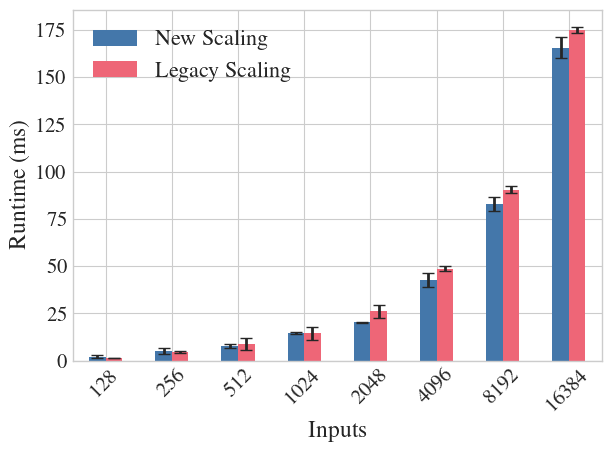

In [4]:
fig, ax = plt.subplots()
mean_cpu = rescaling_data["runtime"]["mean"].xs("CPU", level="type")
std_cpu = rescaling_data["runtime"]["std"].xs("CPU", level="type")

mean_cpu.plot(kind="bar", ax=ax, yerr=std_cpu, capsize=4)
ax.set_xlabel("Inputs")
ax.set_ylabel("Runtime (ms)")
ax.set_xticklabels(mean_cpu.index, rotation=45)

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['New Scaling', 'Legacy Scaling'])

fig.tight_layout()
plt.show()
fig.savefig("micro_benchmarks/data/rescaling_runtime.pdf", format='pdf', bbox_inches='tight')

### CPU-Scalability

#### Rescaling (1-16 Threads)

In [5]:
path_rescaling_scale = get_latest_file("micro_benchmarks/data/scalability", "_rescaling.csv")
print(path_rescaling_scale)

rescaling_scale_data = pd.read_csv(path_rescaling_scale, skipinitialspace=True)
rescaling_scale_data = rescaling_scale_data.drop(columns=["run", "crt_base_size", "type"])
rescaling_scale_data = rescaling_scale_data.groupby(["dims", "nr_threads", 'l']).aggregate(['mean', 'std', relative_std])
rescaling_scale_data = rescaling_scale_data.unstack([-2])
rescaling_scale_data

micro_benchmarks/data/scalability/scalability_2025-03-18_10-13-59_rescaling.csv


runtime                                                  \
                   mean                                                   
nr_threads           1           2           3           4           5    
dims  l                                                                   
128   1       11.176517    9.267961    9.039090    7.710327    6.671629   
      2        9.968352    9.189095    7.153837    5.563211    4.653477   
      3        9.140429    9.101845    7.332976    5.059469    4.913028   
      4        7.004063    8.799246    8.527698    5.899269    4.936907   
      5        8.956884    9.932200    8.437134    6.321751    5.457007   
2048  1      125.766270   91.196224   66.566747   59.866849   51.818615   
      2      108.889033   90.538557   70.641835   49.637333   38.794799   
      3      102.542584   78.291647   53.174542   51.756099   44.716877   
      4      100.958758   76.301939   60.125145   48.026211   40.644867   
      5       99.051444   72.577067   61.804125   45.997480   44.127546   
16384 1     1023.359433  741.719504  514.395078  396.464152  334.616462   
      2      891.654675  630.288804  443.473582  338.483543  273.862769   
      3      843.130030  588.393831  409.934964  317.361385  273.268390   
      4      831.602326  576.884176  391.876299  327.042763  256.978068   
      5      819.921653  598.020665  403.616739  302.048714  248.101076   

                                                                        ...  \
                                                                        ...   
nr_threads          6           7           8           9           10  ...   
dims  l                                                                 ...   
128   1       5.434671    4.871272    4.280012    3.884443    4.018619  ...   
      2       4.596357    3.586231    3.853845    3.019778    3.028054  ...   
      3       4.166175    3.336681    3.219315    3.016483    2.668132  ...   
      4       4.555143    4.199325    3.779092    3.331882    3.590744  ...   
      5       4.872638    4.183785    3.560399    3.505399    3.577911  ...   
2048  1      50.908124   36.736289   43.665211   42.983288   37.838291  ...   
      2      44.049599   37.350238   43.034035   34.764212   30.306915  ...   
      3      39.434368   34.393676   32.605148   36.593276   29.631518  ...   
      4      40.837148   32.878110   31.910914   27.731254   30.841767  ...   
      5      32.944328   31.067191   33.780235   33.229021   32.491980  ...   
16384 1     275.163445  285.213455  316.025090  309.799454  285.377872  ...   
      2     243.167448  219.588304  268.901154  262.149826  240.470630  ...   
      3     245.045362  218.536508  254.411956  250.889403  222.900119  ...   
      4     218.820390  229.365901  250.860051  243.868184  222.040028  ...   
      5     219.312143  191.082023  241.055828  245.352979  225.041953  ...   

                                                                           \
           relative_std                                                     
nr_threads           7         8         9         10        11        12   
dims  l                                                                     
128   1        0.148930  0.152797  0.083536  0.090374  0.159432  0.077727   
      2        0.213487  0.120823  0.172240  0.191152  0.070490  0.262155   
      3        0.250646  0.246603  0.131204  0.272312  0.131246  0.227411   
      4        0.108460  0.097953  0.159097  0.157980  0.167568  0.132246   
      5        0.074134  0.080372  0.110331  0.149258  0.073484  0.084147   
2048  1        0.268958  0.197487  0.103378  0.155176  0.130157  0.153417   
      2        0.218936  0.171416  0.098754  0.149727  0.219611  0.205545   
      3        0.242866  0.218342  0.131400  0.219325  0.156383  0.261296   
      4        0.234829  0.155321  0.061394  0.076065  0.201879  0.200015   
      5        0.177698  0.196933  0.204036  0.132551  0.213363  0.169166   
16384 1   

In [6]:
path_rescaling_scale_DASH = get_latest_file("micro_benchmarks/data/scalability", "IMPORTED_DASH_RESCALING_SCALABILITY.csv")
print(path_rescaling_scale_DASH)

rescaling_scale_data_DASH = pd.read_csv(path_rescaling_scale_DASH, skipinitialspace=True)
rescaling_scale_data_DASH = rescaling_scale_data_DASH.drop(columns=["run", "crt_base_size", "type"])
rescaling_scale_data_DASH = rescaling_scale_data_DASH.groupby(["dims", "nr_threads", 'l']).aggregate(['mean', 'std', relative_std])
rescaling_scale_data_DASH = rescaling_scale_data_DASH.unstack([-2])
rescaling_scale_data_DASH

micro_benchmarks/data/scalability/IMPORTED_DASH_RESCALING_SCALABILITY.csv


runtime                                                      \
                   mean                                                       
nr_threads           1            2            3            4            5    
dims  l                                                                       
128   1       16.987773     9.511086     6.153851     4.861823     4.032677   
      2       32.041207    16.617257    11.765444     9.212877     7.099561   
      3       47.861510    26.301087    17.930691    13.159221    10.860405   
      4       46.799343    34.526848    23.066164    17.783917    15.076867   
      5       60.003015    42.637711    34.230648    26.865441    20.541676   
2048  1      181.768567   130.721645    94.388030    82.773815    69.335678   
      2      365.784033   207.727246   140.620282   104.978310   100.559667   
      3      550.468135   305.548929   211.672719   159.916277   152.998313   
      4      731.588652   385.872718   283.643425   224.926234   208.546460   
      5      916.672351   486.450748   332.089190   280.509339   264.077202   
16384 1     1500.579758   793.453420   551.606457   431.254715   357.260719   
      2     2982.213762  1554.298072  1095.060813   859.233120   705.654680   
      3     4480.583426  2294.104380  1594.187808  1257.008694  1023.411987   
      4     5944.927657  3051.616144  2091.375947  1650.591438  1363.556325   
      5     7412.031539  3795.928158  2621.355273  2048.081903  1696.485875   

                                                                             \
                                                                              
nr_threads           6            7            8            9            10   
dims  l                                                                       
128   1        3.332570     2.946905     2.868688     2.860254     2.560025   
      2        6.260551     5.428773     5.107382     5.574481     4.986652   
      3        9.148730     7.730243     7.308539     8.305112     7.404765   
      4       12.239538    11.217641     9.321455    11.086060     9.812431   
      5       18.603480    14.976796    13.679972    13.095141    11.926473   
2048  1       59.996588    52.017143    50.077389    49.339435    43.689023   
      2       94.063591    88.431205    83.203162    79.683700    78.081678   
      3      128.071815   117.627197   130.662860   122.375214   108.412715   
      4      192.038486   184.016549   175.478514   160.398483   154.432194   
      5      227.010788   210.175907   215.991169   204.156940   188.760778   
16384 1      328.498699   295.260357   282.396830   283.029980   263.791484   
      2      635.891969   560.281157   587.998181   567.861980   513.067935   
      3      941.435822   822.017649   878.556770   837.848590   769.514085   
      4     1225.499439  1062.334917  1154.357332  1113.866434  1022.684398   
      5     1522.686045  1318.888633  1476.187465  1395.427918  1289.926912   

            ...                                                       \
            ... relative_std                                           
nr_threads  ...           7         8         9         10        11   
dims  l     ...                                                        
128   1     ...     0.114445  0.125142  0.012692  0.007480  0.010405   
      2     ...     0.085783  0.147259  0.012709  0.004529  0.009148   
      3     ...     0.009536  0.155594  0.016328  0.007479  0.006461   
      4     ...     0.134435  0.136527  0.016990  0.007463  0.007496   
      5     ...     0.133154  0.138470  0.025672  0.012089  0.010144   
2048  1     ...     0.129761  0.099988  0.088324  0.076564  0.113232   
      2     ...     0.096662  0.072426  0.070022  0.089335  0.095046   
      3     ...     0.145067  0.088992  0.084390  0.053690  0.080601   
      4     ...     0.080328  0.070447  0.090870  0.066242  0.062855   
      5     ...     0.049602  0.087529  0.043362  0.051008  0.050123   
1638

#### Plot

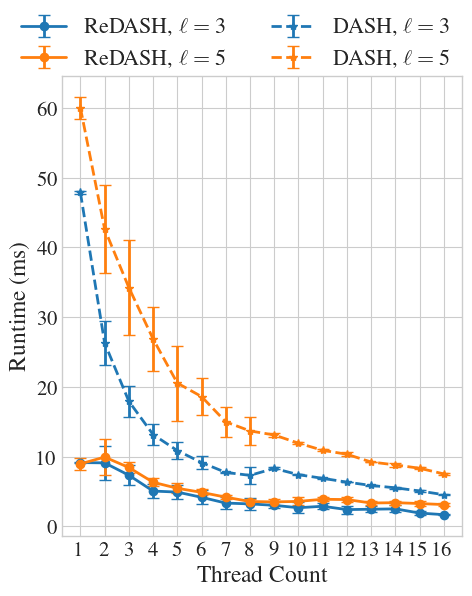

In [34]:
# Get the common dims values between legacy and DASH datasets and keep only the first two
dims_common = sorted(set(rescaling_scale_data.index.get_level_values('dims')).intersection(
                       set(rescaling_scale_data_DASH.index.get_level_values('dims'))))[:1]

fig, axs = plt.subplots(1, len(dims_common), figsize=(5*len(dims_common), 6))

# If only one subplot is created, ensure axs is iterable
if len(dims_common) == 1:
    axs = [axs]

color_l3 = "tab:blue"
color_l5   = "tab:orange"

for ax, d in zip(axs, dims_common):
    # Plot legacy scaling curves (using marker 'o')
    l_values_legacy = sorted(rescaling_scale_data.loc[d].index.unique())
    for l in [3,5]:
        if l == 3:
            color = color_l3
        else:
            color = color_l5
        data = rescaling_scale_data.loc[(d, l)]
        runtime_mean = data['runtime']['mean']
        runtime_std = data['runtime']['std']
        threads = runtime_mean.index.astype(int)
        ax.errorbar(threads, runtime_mean, yerr=runtime_std, marker='o', linestyle='-',
                    color=color, capsize=4, label=f'ReDASH, $\\ell={l}$')
    
    # Plot DASH scaling curves (using marker '*')
    l_values_dash = sorted(rescaling_scale_data_DASH.loc[d].index.unique())
    for l in [3,5]:
        if l == 3:
            color = color_l3
        else:
            color = color_l5
        data = rescaling_scale_data_DASH.loc[(d, l)]
        runtime_mean = data['runtime']['mean']
        runtime_std = data['runtime']['std']
        threads = runtime_mean.index.astype(int)
        ax.errorbar(threads, runtime_mean, yerr=runtime_std, marker='*', linestyle='--',
                    color=color, capsize=4, label=f'DASH, $\\ell={l}$')
    
    # ax.set_title(f"{d} Inputs")
    ax.set_xlabel("Thread Count")
    ax.set_xticks(threads)
    ax.set_ylabel("Runtime (ms)")
    ax.grid(True)

# Create a single legend for all subplots
all_handles = []
all_labels = []
for ax in axs:
    h, l = ax.get_legend_handles_labels()
    all_handles.extend(h)
    all_labels.extend(l)
# Remove duplicates while preserving order
unique = {}
for h, l in zip(all_handles, all_labels):
    if l not in unique:
        unique[l] = h

fig.legend(unique.values(), unique.keys(), loc='upper center', ncol=2,
           bbox_to_anchor=(0.5, 1.02))

fig.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()
fig.savefig("micro_benchmarks/data/rescaling_scale_runtime_comparison.pdf", format='pdf', bbox_inches='tight')


#### Rescaling (CPM Bases, various input sizes)

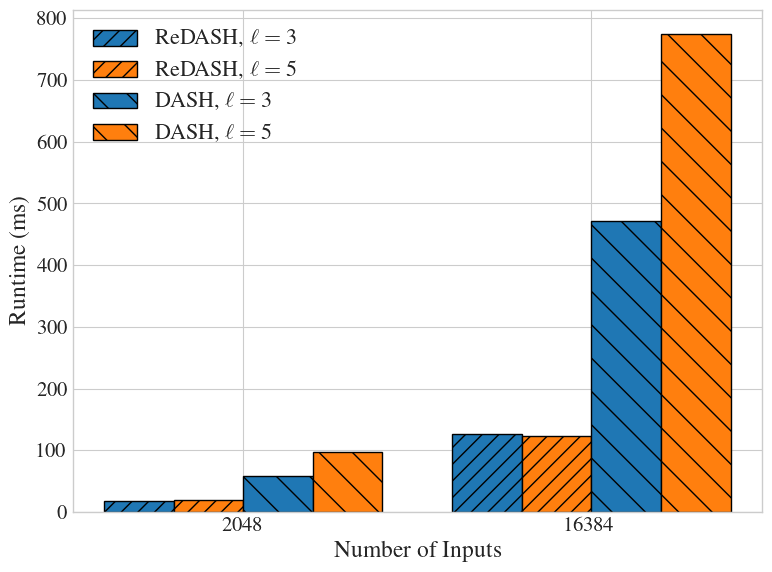

In [ ]:
# Extract runtime means for 16 threads from both datasets.
# For ReDASH:
redash_runtime = rescaling_scale_data["runtime"]["mean"].loc[:, 16]
# For DASH:
dash_runtime = rescaling_scale_data_DASH["runtime"]["mean"].loc[:, 16]

# Define the input counts and the l values of interest.
inputs = [2048, 16384]
l_values = [3, 5]

# Extract the corresponding runtime means.
redash_l3 = redash_runtime.loc[inputs, l_values[0]]
redash_l5 = redash_runtime.loc[inputs, l_values[1]]
dash_l3   = dash_runtime.loc[inputs, l_values[0]]
dash_l5   = dash_runtime.loc[inputs, l_values[1]]

# Set positions for the groups and bars.
positions = np.arange(len(inputs))
bar_width = 0.2
offsets = [-0.3, -0.1, 0.1, 0.3]  # for DASH l=3, DASH l=5, ReDASH l=3, ReDASH l=5

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,6))

# Plot the bars.
ax.bar(positions + offsets[0], redash_l3, width=bar_width, color="tab:blue", hatch="//", edgecolor="black", label="ReDASH, $\\ell=3$")
ax.bar(positions + offsets[1], redash_l5, width=bar_width, color="tab:orange", hatch="//", edgecolor="black", label="ReDASH, $\\ell=5$")
ax.bar(positions + offsets[2], dash_l3, width=bar_width, color="tab:blue", hatch="\\", edgecolor="black", label="DASH, $\\ell=3$")
ax.bar(positions + offsets[3], dash_l5, width=bar_width, color="tab:orange", hatch="\\", edgecolor="black", label="DASH, $\\ell=5$")

# Set x-axis and labels.
ax.set_xticks(positions)
ax.set_xticklabels(inputs)
ax.set_xlabel("Number of Inputs")
ax.set_ylabel("Runtime (ms)")
# ax.set_yscale('log')
ax.legend()

plt.tight_layout()
plt.show()


In [9]:
path_scaling_factor = get_latest_file("micro_benchmarks/data/scalability", "rescaling_scaling_factor.csv")
print(path_scaling_factor)

rescaling_scaling_factor_data = pd.read_csv(path_scaling_factor, skipinitialspace=True)
rescaling_scaling_factor_data = rescaling_scaling_factor_data.drop(columns=["run", "crt_base_size", "type"])
rescaling_scaling_factor_data = rescaling_scaling_factor_data.groupby(["dims", "l"]).aggregate(['mean', 'std', relative_std])
rescaling_scaling_factor_data = rescaling_scaling_factor_data.unstack(-1)
rescaling_scaling_factor_data

micro_benchmarks/data/scalability/scalability_2025-03-18_10-13-59_rescaling_scaling_factor.csv


dims


#### Plot

In [10]:
# # Plot runtime from rescaling_scaling_factor_data for each dims value in a single plot

# fig, ax = plt.subplots(figsize=(8, 6))

# # Determine the l values from the columns (assumed sorted)
# l_values = sorted(rescaling_scaling_factor_data.loc[rescaling_scaling_factor_data.index[0],
#                                                       ('runtime', 'mean')].index)

# markers = ['o', 's', '^']  # Different markers for each dims

# for i, d in enumerate(rescaling_scaling_factor_data.index):
#     # Extract mean runtime and standard deviation across different l values for each dims
#     data_mean = rescaling_scaling_factor_data.loc[d, ('runtime', 'mean')]
#     data_std = rescaling_scaling_factor_data.loc[d, ('runtime', 'std')]
    
#     # Create an errorbar plot with different markers
#     ax.errorbar(l_values, data_mean.values, yerr=data_std.values,
#                 fmt=f"-{markers[i]}", capsize=4, label=f"{d} Inputs")

# ax.set_yscale('log')  # Use a logarithmic scale for the y-axis
# ax.set_xlabel("$\ell$")
# ax.set_ylabel("Runtime (ms)")
# ax.set_xticks(l_values)
# ax.legend()

# fig.tight_layout()
# plt.show()

# # Save the figure as a PDF
# fig.savefig("micro_benchmarks/data/rescaling_scaling_factor_runtime.pdf", format='pdf', bbox_inches='tight')

## Model Benchmarks

In [11]:
path_models = get_latest_file("model_benchmarks/data", "_garbled_models.csv")
# path_models = get_latest_file("model_benchmarks/data", "_sgx_models.csv")
print(path_models)
models_data = pd.read_csv(path_models, skipinitialspace=True)
models_data = models_data[models_data["relu_acc"] == 100]
models_data = models_data.drop(columns=["target_crt_base_size", "label", "infered_label", "relu_acc", "type"])
models_data = models_data.groupby(["model", "optimize_bases"]).aggregate(['mean', 'std', relative_std])
models_data = models_data.unstack()
models_data

model_benchmarks/data/2025-03-15_21-42-49_garbled_models.csv


runtime                                      \
                                   mean                      std              
optimize_bases                        0             1          0          1   
model                                                                         
MODEL_A                       27.338402     20.029919   0.147684   0.416343   
MODEL_B                      167.448427     76.037403   1.477161   0.658601   
MODEL_C                       55.612348     32.162579   0.599106   0.431989   
MODEL_D                      189.401360    129.877796   0.899851   1.534707   
MODEL_F_GNNP_POOL_REPL      7762.104290   5521.465209   9.252211  25.862217   
MODEL_F_MINIONN_POOL_REPL  19473.403653  13656.928813  33.894515  27.317748   

                                                  
                          relative_std            
optimize_bases                       0         1  
model                                             
MODEL_A                       0.005125  0.019719  
MODEL_B                       0.008369  0.008217  
MODEL_C                       0.010220  0.012742  
MODEL_D                       0.004507  0.011210  
MODEL_F_GNNP_POOL_REPL        0.001131  0.004444  
MODEL_F_MINIONN_POOL_REPL     0.001651  0.001898

### Add available data of other frameworks

In [12]:
# Reset the index so that we can iterate through the numbers.
# This will help us to get the x tick positions
df = models_data["runtime"]["mean"]
df = df.reset_index() # Uncomment if you want to use the index as x ticks
# Add data from gnn paper
df["DASH (CPU)"] = [27, 132, 46, 169, 10263, 23959]
# df["DASH (GPU)"] = [10, 32, 16, 42, 1332, 1443]
df

optimize_bases,model,0,1,DASH (CPU)
0,MODEL_A,27.338402,20.029919,27
1,MODEL_B,167.448427,76.037403,132
2,MODEL_C,55.612348,32.162579,46
3,MODEL_D,189.401360,129.877796,169
4,MODEL_F_GNNP_POOL_REPL,7762.104290,5521.465209,10263
5,MODEL_F_MINIONN_POOL_REPL,19473.403653,13656.928813,23959


### Comparison of Dash's model runtimes against other frameworks

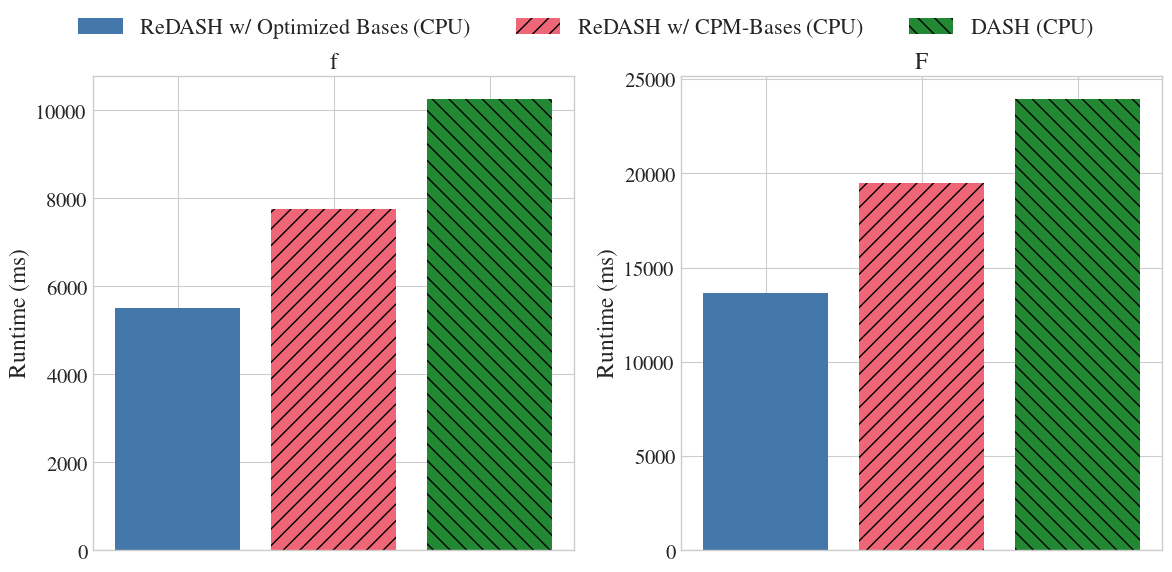

In [13]:
# Filter df for only models F (capital) and f (lowercase)
df_filtered = df[df["model"].isin(["MODEL_F_GNNP_POOL_REPL", "MODEL_F_MINIONN_POOL_REPL"])]

# Create a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Get the runtime columns (excluding "model")
runtime_columns = [col for col in df.columns if col != "model"]
# Swap the first two columns so that the ReDASH bars are switched
runtime_columns[0], runtime_columns[1] = runtime_columns[1], runtime_columns[0]
runtime_labels = [("ReDASH w/ CPM-Bases (CPU)" if col == 0 
                   else "ReDASH w/ Optimized Bases (CPU)" if col == 1 
                   else col) for col in runtime_columns]

# Loop through each filtered model and plot its runtime bars
for i, (idx, row) in enumerate(df_filtered.iterrows()):
    ax_model = axs[i]
    positions = list(range(len(runtime_columns)))
    if 'color_hatch_combinations' not in globals():
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        hatches = ['', '//', '\\\\', '||', '--', '++', 'xx', 'oo', 'OO', '..', '**']
        color_hatch_combinations = [(colors[i % (len(colors)-1)], h) for i, h in enumerate(hatches)]
    for j, col in enumerate(runtime_columns):
        c, h = color_hatch_combinations[j % len(color_hatch_combinations)]
        ax_model.bar(positions[j], row[col], color=c, hatch=h, width=0.8)
    ax_model.set_xticks(positions)
    # Remove x-axis tick labels by not setting them:
    ax_model.set_xticklabels([])
    
    # Remove the "MODEL_" prefix and then rename as needed
    title = row["model"].replace("MODEL_", "")
    if title == "F_GNNP_POOL_REPL":
        title = "f"
    elif title == "F_MINIONN_POOL_REPL":
        title = "F"
    ax_model.set_title(title)
    ax_model.set_ylabel("Runtime (ms)")

# Create a single global legend using custom patches.
import matplotlib.patches as mpatches
legend_handles = []
for j, col in enumerate(runtime_columns):
    c, h = color_hatch_combinations[j % len(color_hatch_combinations)]
    label = "ReDASH w/ CPM-Bases (CPU)" if col == 0 else ("ReDASH w/ Optimized Bases (CPU)" if col == 1 else col)
    patch = mpatches.Patch(facecolor=c, hatch=h, label=label)
    legend_handles.append(patch)

# Place the global legend at the top center
fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=len(runtime_columns))
fig.tight_layout(rect=[0, 0, 1, 0.93])
fig.savefig('model_benchmarks/data/models_runtime_comparison_subplots.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [14]:
print(colors)

['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB', '#000000']


### Runtime Distribution over Layer-Types

In [15]:
path_models = get_latest_file("model_benchmarks/data", "_runtime_distribution_evaluation.csv")
print(path_models)
runtime_dist_data = pd.read_csv(path_models, skipinitialspace=True)
runtime_dist_data[runtime_dist_data["relu_acc"] == 100]

runtime_dist_data = runtime_dist_data.drop(columns=["target_crt_base_size", "relu_acc", "type"])
runtime_dist_data = runtime_dist_data.groupby(["model", "layer", "optimize_bases"]).aggregate(['mean', 'std', relative_std])

# add 0 second entries for missing layers (not all models contain all layers)
runtime_dist_data = runtime_dist_data.unstack(0)["runtime"]["mean"]
runtime_dist_data.fillna(0, inplace=True)
runtime_dist_data

model_benchmarks/data/2025-03-15_22-35-04_runtime_distribution_evaluation.csv


model                         MODEL_A    MODEL_B    MODEL_C     MODEL_D  \
layer       optimize_bases                                                
approx_relu 0                3.340966  65.498009  18.267201   35.797969   
            1                2.652300  22.123855   9.269260   26.263090   
conv2d      0                0.000000  64.295660   9.760599  128.223173   
            1                0.000000  36.426371   6.496752   83.292021   
dense       0               21.748101   1.648518  17.886527    5.827985   
            1               15.780686   0.944872  11.324902    3.895349   
rescale     0                2.166102  34.633080   9.820471   20.658060   
            1                1.556359  16.091757   5.450618   15.089710   

model                       MODEL_F_GNNP_POOL_REPL  MODEL_F_MINIONN_POOL_REPL  
layer       optimize_bases                                                     
approx_relu 0                           598.048039                1087.025770  
            1                           577.333452                1030.775501  
conv2d      0                          6764.580329               17671.203667  
            1                          4601.424820               12006.967120  
dense       0                             0.554708                   0.611852  
            1                             0.450117                   0.502921  
rescale     0                           380.575789                 677.067313  
            1                           331.259584                 596.738840

In [16]:
path_models = get_latest_file("model_benchmarks/data", "IMPORTED_DASH_RUNTIME_DISTRIBUTION_EVALUATION.csv")
print(path_models)
runtime_dist_data_DASH = pd.read_csv(path_models, skipinitialspace=True)

# Only keep rows with relu_acc==100 and where "type" is not "GPU"
runtime_dist_data_DASH = runtime_dist_data_DASH[(runtime_dist_data_DASH["relu_acc"] == 100) & (runtime_dist_data_DASH["type"] != "GPU")]

runtime_dist_data_DASH = runtime_dist_data_DASH.drop(columns=["target_crt_base_size", "relu_acc", "type"])
runtime_dist_data_DASH = runtime_dist_data_DASH.groupby(["model", "layer"]).aggregate(['mean', 'std', relative_std])

# Add 0 second entries for missing layers (not all models contain all layers)
runtime_dist_data_DASH = runtime_dist_data_DASH.unstack(0)["runtime"]["mean"]
runtime_dist_data_DASH.fillna(0, inplace=True)
runtime_dist_data_DASH

model_benchmarks/data/IMPORTED_DASH_RUNTIME_DISTRIBUTION_EVALUATION.csv


model,MODEL_F_GNNP_POOL_REPL,MODEL_F_MINIONN_POOL_REPL
layer,,
approx_relu,563.247330,1020.694600
conv2d,6758.794100,17641.739731
dense,0.559952,0.620049
rescale,2932.377561,5366.513316


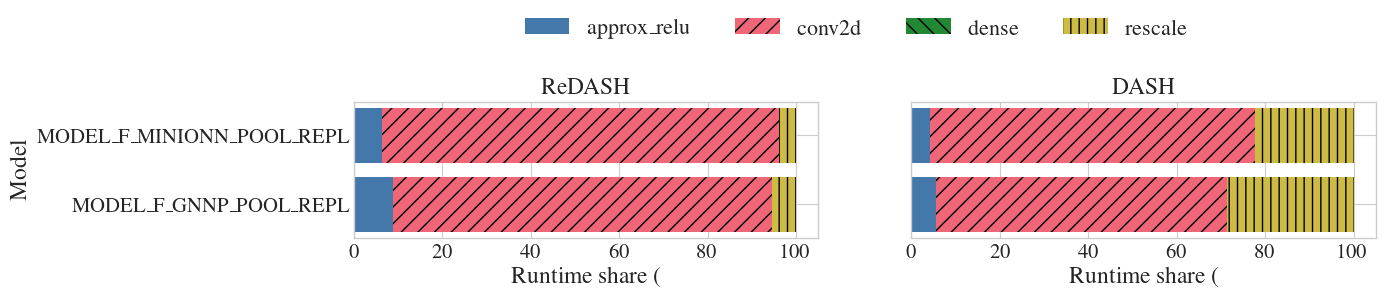

In [17]:
# Select only the two models corresponding to f and F.
model_names = ["MODEL_F_GNNP_POOL_REPL", "MODEL_F_MINIONN_POOL_REPL"]

# For runtime_dist_data, the index is multi-index (layer, optimize_bases).
# Sum over optimize_bases so that each layer gets a single value per model.
df_redash = runtime_dist_data[model_names].groupby(level=0).sum()
# For runtime_dist_data_DASH, the index is simply the layer.
df_dash = runtime_dist_data_DASH[model_names]

# Determine the layer order.
# For ReDASH, note that the available layers are in the index of df_redash.
layer_order_redash = list(df_redash.index)
# For DASH, use the order as it appears (or force a consistent order if desired).
layer_order_dash = list(df_dash.index)

# Compute percentage contributions per layer for each model.
def compute_percentages(df, models, layers):
    # Create a dict: key=layer, value = list of percentages across models
    data = {layer: [] for layer in layers}
    for m in models:
        total = df[m].sum()
        for layer in layers:
            pct = (df.loc[layer, m] / total * 100) if total!=0 else 0
            data[layer].append(pct)
    return data

redash_percent = compute_percentages(df_redash, model_names, layer_order_redash)
dash_percent = compute_percentages(df_dash, model_names, layer_order_dash)

# Set up colors and hatches.
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
hatches = ['', '//', '\\\\', '||', '--', '++', 'xx', 'oo', 'OO', '..', '**']
color_hatch_combinations = [(colors[i % (len(colors)-1)], hatches[i % len(hatches)]) for i in range(max(len(layer_order_redash), len(layer_order_dash)))]

# Create subplots: left for ReDASH, right for DASH.
fig, axs = plt.subplots(1, 2, figsize=(12, 3), sharey=True)
fig.tight_layout(pad=3)

# For both axes, the y-axis corresponds to the two models.
y_positions = range(len(model_names))

# Plot for ReDASH.
left = [0, 0]  # starting left position for each model bar (two models)
for idx, layer in enumerate(layer_order_redash):
    c, h = color_hatch_combinations[idx]
    axs[0].barh(model_names, redash_percent[layer], left=left, label=layer, color=c, hatch=h)
    left = [l + v for l, v in zip(left, redash_percent[layer])]
axs[0].set_title("ReDASH")
axs[0].set_xlabel("Runtime share (%)")
axs[0].set_ylabel("Model")

# Plot for DASH.
left_dash = [0, 0]
for idx, layer in enumerate(layer_order_dash):
    c, h = color_hatch_combinations[idx]
    axs[1].barh(model_names, dash_percent[layer], left=left_dash, label=layer, color=c, hatch=h)
    left_dash = [l + v for l, v in zip(left_dash, dash_percent[layer])]
axs[1].set_title("DASH")
axs[1].set_xlabel("Runtime share (%)")

# Create a combined legend (using those from the left subplot).
# Here we combine the labels from both plots; the order is taken from layer_order_redash.
all_handles = []
for idx, layer in enumerate(layer_order_redash):
    c, h = color_hatch_combinations[idx]
    patch = plt.matplotlib.patches.Patch(facecolor=c, hatch=h, label=layer)
    all_handles.append(patch)
fig.legend(handles=all_handles, loc='upper center', ncol=len(layer_order_redash), bbox_to_anchor=(0.5, 1.1))

fig.savefig("model_benchmarks/data/runtime_distribution_Fmodels.pdf", format='pdf', bbox_inches='tight')
plt.show()


{'approx_relu': [577.3334523, 1030.7755013], 'conv2d': [4601.4248201, 12006.9671198], 'dense': [0.4501167, 0.5029209], 'rescale': [331.25958380000003, 596.7388401000001]}
{'approx_relu': [598.0480392000001, 1087.02577], 'conv2d': [6764.580328599999, 17671.203667100002], 'dense': [0.5547079, 0.6118518], 'rescale': [380.5757887, 677.0673133]}
{'approx_relu': [563.24733, 1020.6946005], 'conv2d': [6758.794099999999, 17641.739731], 'dense': [0.559952, 0.6200490000000001], 'rescale': [2932.3775605, 5366.513316]}


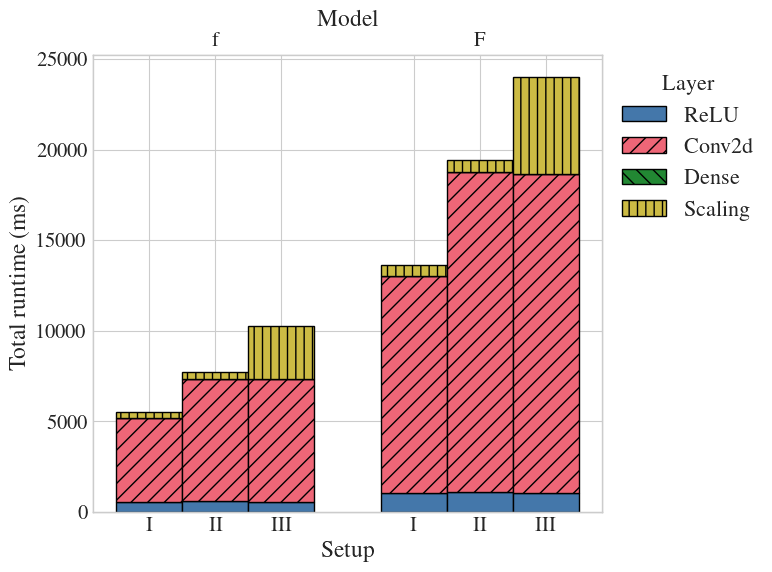

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


df_redash_optim = runtime_dist_data[model_names].xs(1, level="optimize_bases")
df_redash_cpm   = runtime_dist_data[model_names].xs(0, level="optimize_bases")
df_dash         = runtime_dist_data_DASH[model_names]  # already has a single index: layer

# Determine layer order for each dataset.
# For ReDASH use the union of layers from the two optimize_bases values
layer_order_redash = sorted(set(df_redash_optim.index).union(df_redash_cpm.index))
layer_order_dash   = list(df_dash.index)

# Use the union order for plotting across datasets
layers = layer_order_redash

# Function to compute total runtime contributions per layer for each model.
def compute_totals(df, models, layers):
    # Returns a dict: key=layer, value = list of total runtimes per model
    data = {layer: [] for layer in layers}
    for m in models:
        for layer in layers:
            # If a layer is missing in the dataframe, use 0.
            val = df.loc[layer, m] if layer in df.index else 0
            data[layer].append(val)
    return data

# Compute total runtime values instead of percentages.
redash_optim_total = compute_totals(df_redash_optim, model_names, layers)
redash_cpm_total   = compute_totals(df_redash_cpm,   model_names, layers)
dash_total         = compute_totals(df_dash,         model_names, layers)

print(redash_optim_total)
print(redash_cpm_total)
print(dash_total)

# Define the three dataset categories to compare.
datasets = ["ReDASH Optimized", "ReDASH CPM", "DASH"]
n_datasets = len(datasets)
n_models = len(model_names)
bar_width = 0.25

# x positions for model groups.
indices = np.arange(n_models)

# Create a mapping for layers to style using the pre-defined color_hatch_combinations.
layer_style = {layer: color_hatch_combinations[i % len(color_hatch_combinations)]
                for i, layer in enumerate(layers)}

# Setup the figure.
fig, ax = plt.subplots(figsize=(8, 6))

# Plot bars for each dataset category.
# Offsets: centered grouping per model.
for i, dataset in enumerate(datasets):
    pos = indices + (i - (n_datasets - 1) / 2) * bar_width
    for j, m in enumerate(model_names):
        if dataset == "ReDASH Optimized":
            ser = pd.Series({layer: redash_optim_total.get(layer, [0]*n_models)[j] for layer in layers})
        elif dataset == "ReDASH CPM":
            ser = pd.Series({layer: redash_cpm_total.get(layer, [0]*n_models)[j] for layer in layers})
        elif dataset == "DASH":
            ser = pd.Series({layer: dash_total.get(layer, [0]*n_models)[j] for layer in layers})
        bottom = 0
        for layer in layers:
            val = ser[layer]
            c, h = layer_style[layer]
            ax.bar(pos[j], val, bar_width, bottom=bottom, color=c, hatch=h, edgecolor='black')
            bottom += val

# Set x-axis: one tick per model (using the center of grouped bars)
ax.set_xticks(indices)
# Replace model names with short labels: f and F.
model_labels = {"MODEL_F_GNNP_POOL_REPL": "f", "MODEL_F_MINIONN_POOL_REPL": "F"}
# ax.set_xticklabels([model_labels[m] for m in model_names])
# ax.set_xlabel("Model")
ax.set_ylabel("Total runtime (ms)")

# Instead of placing model labels at the default bottom,
# we remove the current ticks and set two x-axis labels.
# 1. Bottom ticks for dataset categories (I, II, III) for each model.
roman = ["I", "II", "III"]
tick_positions = []
tick_labels = []
for x in indices:
    for i in range(n_datasets):
        tick_positions.append(x + (i - (n_datasets - 1)/2)*bar_width)
        tick_labels.append(roman[i])
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
ax.set_xlabel("Setup")

# 2. Create a twin x-axis at the top for the model labels (f and F).
ax_top = ax.twiny()
ax_top.set_xlim(ax.get_xlim())
ax_top.set_xticks(indices)
ax_top.set_xticklabels([model_labels[m] for m in model_names])
ax_top.xaxis.set_ticks_position('top')
ax_top.xaxis.set_label_position('top')
ax_top.set_xlabel("Model")
ax_top.set_zorder(-1)

layer_label = {
    'approx_relu': 'ReLU',
    'conv2d': 'Conv2d',
    'dense': 'Dense',
    'rescale': 'Scaling'
}

# Create a combined legend for layers.
legend_handles = [mpatches.Patch(facecolor=layer_style[layer][0],
                                 hatch=layer_style[layer][1],
                                 edgecolor='black',
                                 label=layer_label.get(layer, layer))
                  for layer in layers]
ax.legend(handles=legend_handles, title="Layer", bbox_to_anchor=(1, 1))

fig.tight_layout()

# Optionally, save the figure:
fig.savefig("model_benchmarks/data/vertical_combined_runtime_distribution.pdf", format='pdf', bbox_inches='tight')
plt.show()


In [19]:
cpm_dict = {
    3: [2,3,5],
    4: [2,3,5,7],
    5: [2,3,5,7,11],
    6: [2,3,5,7,11,13],
    7: [2,3,5,7,11,13,17],
    8: [2,3,5,7,11,13,17,19]
}

mrs_dict = {
    3: [32],
    4: [26,3],
    5: [54,4,3],
    6: [60,125],
    7: [86,7,36,5],
    8: [92,7,6,125,4]
}

def redash_ciphertexts(k):
    crt_base = cpm_dict[k]
    p_k = crt_base[-1]

    sum = 0
    for i in range(1, k):
        sum += p_k * (k-i)
    return sum

def dash_cipher_texts(k):
    crt_base = cpm_dict[k]
    mrs_base = mrs_dict[k]
    t = len(mrs_base)

    sum1 = 0
    for i in range(0, k):
        sum1 += crt_base[i]
    sum1 *= t

    sum2 = 0
    for i in range(1, t):
        sum2 += (mrs_base[i] + 2 * t * (k-1))
    sum2 *= 2 * k
    

    sum3 = mrs_base[0]

    base_change_projection_ciphertexts = 2 * (k-1)

    return sum1 + sum2 + sum3 + base_change_projection_ciphertexts

In [20]:
redash_data = [redash_ciphertexts(k) for k in range(3, 9)]
print(redash_data)
dash_data = [dash_cipher_texts(k) for k in range(3, 9)]
print(dash_data)


[15, 42, 110, 195, 357, 532]
[46, 186, 696, 1892, 3018, 7243]


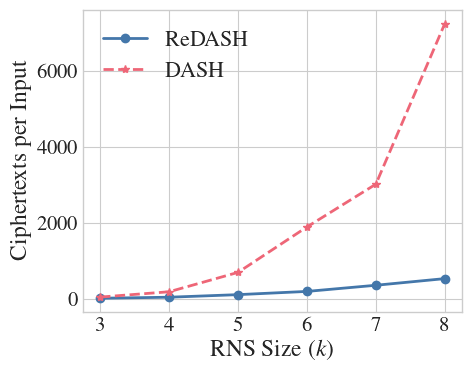

In [21]:
# Define k values corresponding to the data points
k_values = list(range(3, 9))

plt.figure(figsize=(5, 4))
plt.plot(k_values, redash_data, marker='o', linestyle='-', label="ReDASH")
plt.plot(k_values, dash_data, marker='*', linestyle='--', label="DASH")

plt.xlabel("RNS Size ($k$)")
plt.ylabel("Ciphertexts per Input")
plt.yscale('linear')  # set y-axis to a normal (linear) scale
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("micro_benchmarks/data/ciphertexts_per_input.pdf", format="pdf", bbox_inches="tight")
plt.show()